In [257]:
import pretraining

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datapane as dp
import pygam

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Dữ liệu
Tại đây, tôi sử dụng bộ dữ liệu bệnh tiểu đường được đề xuất trên Kaggle https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset.

In [259]:
df = pretraining.readCSV("diabetes_prediction_dataset.csv")
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


Kiểm tra các giá trị có thể có của hai thuộc tính Categorial để có thể đưa ra những xử lý hợp lý (bước này không cần thiết cho bài viết này, vì chúng ta chỉ xem xét sự thay đổi của khả năng mắc bệnh dựa trên tuổi).

In [260]:
df['smoking_history'].value_counts()

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

In [261]:
df['gender'].value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

In [262]:
mapping_dictionary_smoking_history = {
    "No Info": 0,
    "never": 4,
    "former": 3,
    "current": -1,
    "not current": 2,
    "ever": 1
}
mapping_dictionary_gender = {
    "Female": -1,
    "Male": 1,
    "Other" : 0
}
df.replace({"smoking_history": mapping_dictionary_smoking_history, "gender": mapping_dictionary_gender}, inplace=True)

In [263]:
df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.171220,41.885856,0.07485,0.039420,1.76048,27.320767,5.527507,138.058060,0.085000
std,0.985146,22.516840,0.26315,0.194593,1.93608,6.636783,1.070672,40.708136,0.278883
min,-1.000000,0.080000,0.00000,0.000000,-1.00000,10.010000,3.500000,80.000000,0.000000
25%,-1.000000,24.000000,0.00000,0.000000,0.00000,23.630000,4.800000,100.000000,0.000000
50%,-1.000000,43.000000,0.00000,0.000000,2.00000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.00000,0.000000,4.00000,29.580000,6.200000,159.000000,0.000000
max,1.000000,80.000000,1.00000,1.000000,4.00000,95.690000,9.000000,300.000000,1.000000


In [264]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,-1,80.0,0,1,4,25.19,6.6,140,0
1,-1,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,-1,36.0,0,0,-1,23.45,5.0,155,0
4,1,76.0,1,1,-1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,-1,80.0,0,0,0,27.32,6.2,90,0
99996,-1,2.0,0,0,0,17.37,6.5,100,0
99997,1,66.0,0,0,3,27.83,5.7,155,0
99998,-1,24.0,0,0,4,35.42,4.0,100,0


In [265]:
df['diabetes'].value_counts()

0    91500
1     8500
Name: diabetes, dtype: int64

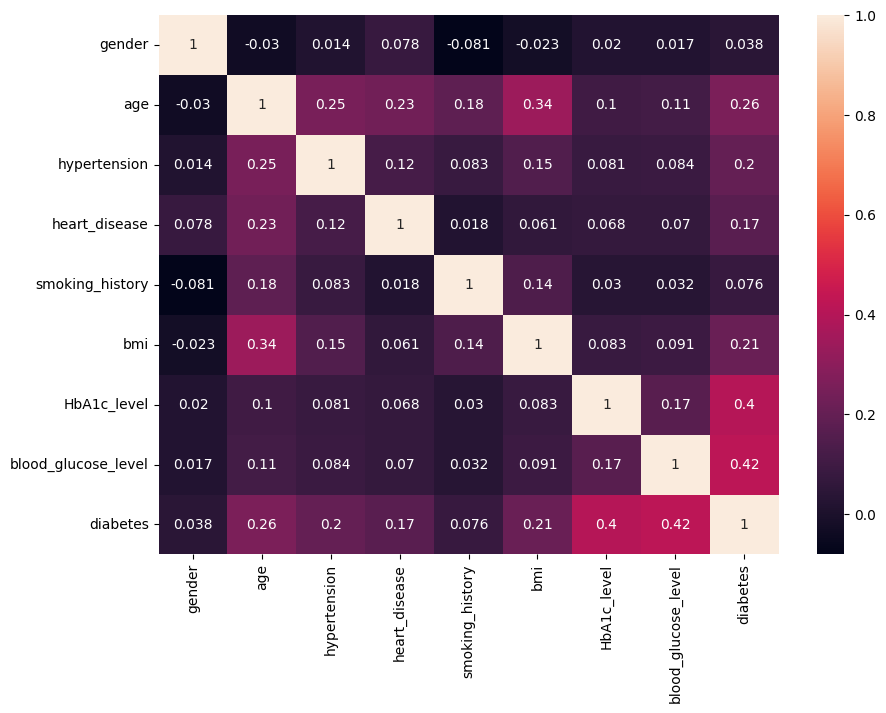

In [266]:
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(df.corr(),annot=True);

# Xử lý dữ liệu
Tại đây, ta nhóm các giá trị dự đoán bệnh dựa trên tuổi. Các dự đoán ở cùng một độ tuổi sẽ được tính trung bình thay vì trung vị. Điều này trả về giá trị xác suất khả năng mắc bệnh tại một độ tuổi cụ thể.

In [267]:
median_df = df[['age','diabetes']].groupby('age').mean().reset_index()
median_df

,age,diabetes
0,0.08,0.000000
1,0.16,0.000000
2,0.24,0.000000
3,0.32,0.000000
4,0.40,0.000000
...,...,...
97,76.00,0.203274
98,77.00,0.186301
99,78.00,0.199413
100,79.00,0.227053


In [268]:
plot = px.scatter(data_frame=median_df,
                  x='age',
                  y='diabetes',
                  title='Growth of probability of having diabetes')
plot.data[0].update(mode='markers+lines')
plot.update_layout(xaxis={'dtick':1},showlegend=True)
report = dp.View(df, dp.Text("My Dataframe"))
plot

Thông qua đồ thị, ta nhận thấy rằng, xác suất khả năng mắc bệnh không phụ thuộc tuyến tính vào độ tuổi.

# Hồi quy tuyến tính

In [269]:
model=LinearRegression()
model.fit(median_df[['age']],median_df['diabetes'])
median_df['Linear Regression'] = model.predict(median_df[['age']])

plot = px.scatter(data_frame=median_df,
                  x='age',
                  y=['diabetes','Linear Regression'],title='Linear Regression for probability of having diabetes')

plot.data[0].update(mode='markers+lines')
plot.data[1].update(mode='markers+lines')
plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.3,y=-.3))

report = dp.View(df, dp.Text("My Dataframe"))
plot

Do đó, một hàm tuyến tính không có khả năng mô hình hóa một cách chính xác các giá trị đạt được.

# Hồi quy đa thức

In [270]:
poly = PolynomialFeatures(30)
poly_df = pd.DataFrame(poly.fit_transform(median_df[['age']]),columns = poly.get_feature_names_out())
poly_df.head(2)

,1,age,age^2,age^3,age^4,age^5,age^6,age^7,age^8,age^9,...,age^21,age^22,age^23,age^24,age^25,age^26,age^27,age^28,age^29,age^30
0,1.0,0.08,0.0064,0.000512,0.000041,0.000003,2.621440e-07,2.097152e-08,1.677722e-09,1.342177e-10,...,9.223372e-24,7.378698e-25,5.902958e-26,4.722366e-27,3.777893e-28,3.022315e-29,2.417852e-30,1.934281e-31,1.547425e-32,1.237940e-33
1,1.0,0.16,0.0256,0.004096,0.000655,0.000105,1.677722e-05,2.684355e-06,4.294967e-07,6.871948e-08,...,1.934281e-17,3.094850e-18,4.951760e-19,7.922816e-20,1.267651e-20,2.028241e-21,3.245186e-22,5.192297e-23,8.307675e-24,1.329228e-24


In [271]:
vals = [1,3,5,10,20]
vals_col = []

In [272]:
for val in vals:
    n = val
    end = median_df.shape[0]-2

    model=LinearRegression()
    model.fit(poly_df.iloc[:end,:n+1],median_df['diabetes'][:end])
    median_df[f'x^{n}'] = model.predict(poly.transform(median_df[['age']])[:,:n+1])
    vals_col.append(f'x^{n}')

c:\Users\NGOCDUC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\NGOCDUC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\NGOCDUC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\NGOCDUC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\NGOCDUC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [273]:
plot = px.scatter(data_frame=median_df,
                  x='age',
                  y=['diabetes']+vals_col,
                 title='Polynomial Regression for probability of having diabetes')

for i in plot.data:
    i.update(mode='markers+lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.3,y=-.3))
# plot.update_yaxes(range=[0,500])
report = dp.View(df, dp.Text("My Dataframe"))
plot

Ta nhận thấy rằng, nếu bậc của input càng lớn thì khả năng dự đoán sẽ tốt hơn. Nhưng khi vượt qua một điểm nào đó, kết quả dự đoán tại các điểm biên vô cùng tệ. Điều này có thể thấy rõ trên đồ thị với hồi quy đa thức có bậc 20 tại độ tuổi trên 77.

Điều này xảy ra là do hồi quy đa thức gặp phải hiệu ứng Runge. Có hai nguyên nhân là:
- Các giá trị sinh ra từng bậc mũ có thể tăng nhanh theo chiều tăng của bậc.
- Các khoảng cách đều nhau giữa các điểm sẽ dẫn đến hằng số Lebesgue.

Từ đó, ta có thể đưa ra nhận xét rằng, các đa thức bậc cao không hẳn luôn là cách hiệu quả để cải thiện độ chính xác.

In [274]:
median_df.head()

,age,diabetes,Linear Regression,x^1,x^3,x^5,x^10,x^20
0,0.08,0.0,-0.025181,-0.025155,0.005710,0.000729,0.001276,0.009665
1,0.16,0.0,-0.024951,-0.024925,0.005531,0.000686,0.001276,0.009665
2,0.24,0.0,-0.024721,-0.024695,0.005353,0.000646,0.001276,0.009665
3,0.32,0.0,-0.024491,-0.024465,0.005178,0.000607,0.001276,0.009665
4,0.40,0.0,-0.024261,-0.024235,0.005003,0.000569,0.001276,0.009665


In [275]:
from pygam import GAM, LinearGAM, s, f, te

In [276]:
lams = np.logspace(-5,5,20)

In [277]:
end = median_df.shape[0]-2
splines = 12

In [278]:
gam = LinearGAM(s(0,n_splines=splines)).gridsearch(median_df[['age']].iloc[:end].values,
                                               median_df['diabetes'][:end].values,
                                               lam=lams)

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 35% (7 of 20) |########                 | Elapsed Time: 0:00:00 ETA:  00:00:00
 75% (15 of 20) |##################      | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [279]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.9332
Link Function:                     IdentityLink Log Likelihood:                              -1107121.7252
Number of Samples:                          100 AIC:                                          2214267.3168
                                                AICc:                                          2214270.862
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                   0.9942
Feature Function                  Lam

C:\Users\NGOCDUC\AppData\Local\Temp\ipykernel_12424\3358381670.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [280]:
median_df[f'GAM {splines} splines'] = gam.predict(median_df[['age']])

In [281]:
plot = px.scatter(data_frame=median_df,
                  x='age',
                  y=['diabetes',f'GAM {splines} splines'],
                 title=f'GAM {splines} splines on probability of having diabetes <br>Ages 77, 78, 79, 80 Predicted')

for i in plot.data:
    i.update(mode='markers+lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.3,y=-.3))
# plot.update_yaxes(range=[0,500])
report = dp.View(df, dp.Text("My Dataframe"))
plot

Trong khi đó, GAM dường như khắc phục được vấn đề xảy ra bởi hồi quy đa thức. Cụ thể, các giá trị tại biên không xuất hiện những sai lệch đáng kể như trên.

In [282]:
coefs = gam.coef_

In [283]:
matrix = pd.DataFrame(gam._modelmat(median_df[['age']].iloc[:end].values).toarray())

In [284]:
matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.166667,0.666667,0.166667,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
1,0.162089,0.666582,0.171329,1.314920e-07,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
2,0.157596,0.666328,0.176075,1.051936e-06,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
3,0.153187,0.665909,0.180901,3.550285e-06,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
4,0.148861,0.665326,0.185805,8.415489e-06,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.016437,0.455091,0.502521,0.025952,1.0
96,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.006934,0.379153,0.567400,0.046512,1.0
97,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.002055,0.302688,0.619467,0.075791,1.0
98,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000257,0.230318,0.654096,0.115329,1.0


In [285]:
matrix.shape

(100, 13)

In [286]:
plot = px.scatter(data_frame=matrix,
                  x= matrix.index,
                  y= matrix.columns,
                 title=f'Spline Functions for {splines} spline GAM')

for i in plot.data:
    i.update(mode='lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.52,y=-.3))
#plot.update_yaxes(range=[0,500])
report = dp.View(df, dp.Text("My Dataframe"))
plot

In [287]:
coefs

array([-0.06701128, -0.0721419 , -0.06182782, -0.06227347, -0.05670598,
       -0.03791283, -0.00789063,  0.03201248,  0.10302647,  0.16066213,
        0.15303963, -0.01374004,  0.06923675])

In [288]:
scaled_matrix = matrix*coefs

In [289]:
plot = px.scatter(data_frame=scaled_matrix,
                  x= scaled_matrix.index,
                  y= scaled_matrix.columns,
                 title=f'Spline Functions * Coefficients for {splines} spline GAM')

for i in plot.data:
    i.update(mode='lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.52,y=-.3))
#plot.update_yaxes(range=[0,500])
report = dp.View(df, dp.Text("My Dataframe"))
plot

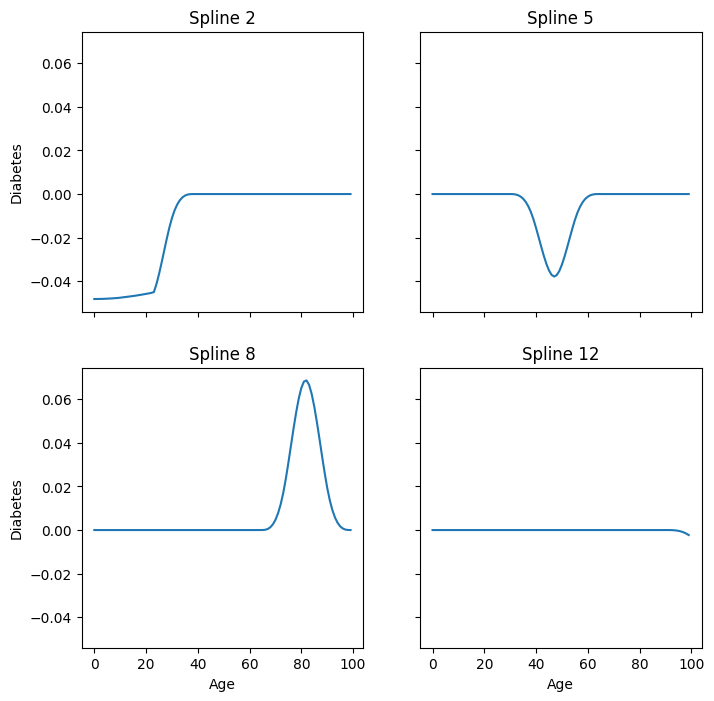

In [290]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize = (8,8),sharey=True, sharex=True)
(matrix*coefs)[1].plot(title = 'Spline 2', ax=ax[0,0])
(matrix*coefs)[4].plot(title = 'Spline 5', ax=ax[0,1])
(matrix*coefs)[8].plot(title = 'Spline 8', ax=ax[1,0])
(matrix*coefs)[11].plot(title = 'Spline 12', ax=ax[1,1])
plt.setp(ax[-1, :], xlabel='Age')
plt.setp(ax[:, 0], ylabel='Diabetes')
plt.show()